# Introduction
## The problem
* For people who saw the promotion commercial at Channel KLMN, Los Angeles viewers showed a higher watching rate (i.e., higher fraction of people who watch) of “US Politics This Week” than viewers from other cities
* Executive producer suggested to make new promotion commercials which are tailored to big cities in the US by featuring their Mayors
* Channel KLMN designed and conducted an experiment to test whether the new commercial works
* After the A/B test, surprisingly the results showed that the old commercial was doing better. The fraction of people watching the show decreased when they viewed the new commercial

## The datasets

### test
* General info about the test results
* Columns:
    * viewer_id
    * date
    * tv_make
    * tv_size
    * uhd_capable
    * tv_provider
    * total_time_watched
    * watched
    * test

### viewer
* Info about the users
* Columns:
    * viewer_id
    * gender
    * age
    * city

## The Questions
1. Reproduce the negative result found above. Is it actually negative?
2. Explain what might be happening. Are the commercials with local Mayors really driving a lower fraction of people to watch the show?
3. If you identify anything wrong, design an algorithm that would return False if the same problem happens in the future. If nothing is wrong, provide recommendations regarding whether or not they should continue airing the new commercials

In [3]:
# Import libraries
%matplotlib inline
import numpy as np
import pandas as pd
import pandas_profiling as pp
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import scipy
from scipy import stats
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels import stats
from statsmodels.stats import proportion
from statsmodels.stats.proportion import proportions_ztest

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')

# Load data and data housekeeping 

## Test data set

In [31]:
test = pd.read_csv('./Data/test_data.csv', parse_dates=['date'])
test.head()

,viewer_id,date,tv_make,tv_size,uhd_capable,tv_provider,total_time_watched,watched,test
0,24726768,2018-01-16,Sony,70,0,Comcast,10.75,0,1
1,25001464,2018-01-18,Sony,32,0,NaN,2.75,0,0
2,28291998,2018-01-18,Sony,50,1,Dish Network,20.00,0,0
3,17057157,2018-01-19,Sony,32,0,Comcast,1.50,0,0
4,29504447,2018-01-17,Sony,32,0,Comcast,17.50,0,0


Get to know more about the data, i.e., data quality, descriptive info, etc.

In [32]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418026 entries, 0 to 418025
Data columns (total 9 columns):
viewer_id             418026 non-null int64
date                  418026 non-null datetime64[ns]
tv_make               418026 non-null object
tv_size               418026 non-null int64
uhd_capable           418026 non-null int64
tv_provider           365306 non-null object
total_time_watched    418026 non-null float64
watched               418026 non-null int64
test                  418026 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(5), object(2)
memory usage: 28.7+ MB


In [33]:
test.describe(include='all')

,viewer_id,date,tv_make,tv_size,uhd_capable,tv_provider,total_time_watched,watched,test
count,4.180260e+05,418026,418026,418026.000000,418026.000000,365306,418026.000000,418026.000000,418026.000000
unique,NaN,5,4,NaN,NaN,5,NaN,NaN,NaN
top,NaN,2018-01-15 00:00:00,Sony,NaN,NaN,Comcast,NaN,NaN,NaN
freq,NaN,86641,271922,NaN,NaN,109796,NaN,NaN,NaN
first,NaN,2018-01-15 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2018-01-19 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.835585e+07,NaN,NaN,51.874111,0.200858,NaN,10.039700,0.054547,0.488790
std,1.248317e+07,NaN,NaN,12.225413,0.400643,NaN,6.179722,0.227094,0.499875
min,1.000000e+04,NaN,NaN,32.000000,0.000000,NaN,0.250000,0.000000,0.000000
25%,7.526723e+06,NaN,NaN,40.000000,0.000000,NaN,5.000000,0.000000,0.000000


In [34]:
pp.ProfileReport(test)

Number of variables,9
Number of observations,418026
Total Missing (%),1.4%
Total size in memory,28.7 MiB
Average record size in memory,72.0 B
Numeric,3
Categorical,2
Boolean,3
Date,1
Text (Unique),0
Rejected,0


In [35]:
# Check if there are duplicates
sum(test.duplicated())

0

The test data is clean. There are no duplicates, no messy entries. Only TV provider has missing values.

As showed in the ProfileReport, there were 51.1% viewers in the control group and 48.9% viewers in the experiment group. Without considering further details, the sample size is a fairly even for control and experiment groups.

## Viewer data set

In [36]:
viewer = pd.read_csv('./Data/viewer_data.csv')
viewer.head()

,viewer_id,gender,age,city
0,1918165,Female,39,Dallas
1,27662619,Female,28,New York
2,5493662,Female,53,Detroit
3,14441247,Male,41,New York
4,25595927,Male,53,Seattle


In [37]:
viewer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417464 entries, 0 to 417463
Data columns (total 4 columns):
viewer_id    417464 non-null int64
gender       417464 non-null object
age          417464 non-null int64
city         417464 non-null object
dtypes: int64(2), object(2)
memory usage: 12.7+ MB


In [38]:
viewer.describe(include='all')

,viewer_id,gender,age,city
count,4.174640e+05,417464,417464.000000,417464
unique,NaN,2,NaN,15
top,NaN,Female,NaN,New York
freq,NaN,209416,NaN,69893
mean,1.837908e+07,NaN,40.473298,NaN
std,1.247548e+07,NaN,12.056198,NaN
min,1.000000e+04,NaN,18.000000,NaN
25%,7.571130e+06,NaN,31.000000,NaN
50%,1.841588e+07,NaN,39.000000,NaN
75%,2.917900e+07,NaN,48.000000,NaN


In [39]:
pp.ProfileReport(viewer)

Number of variables,4
Number of observations,417464
Total Missing (%),0.0%
Total size in memory,12.7 MiB
Average record size in memory,32.0 B
Numeric,2
Categorical,2
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [40]:
# Check if there are duplicates
sum(viewer.duplicated())

0

The test data is clean. There are no duplicates or missing values.

# Reproduce the negative A/B test results

Because we are interested in comparing the watching rates, i.e., the fraction of people watched the show, between experiment group and control group, for rates, to test statistical difference, we need to use proportional z test

In [41]:
exp_watched = sum(test[test.test == 1].watched)
exp_n = len(test[test.test == 1])

In [42]:
ctrl_watched = sum(test[test.test == 0].watched)
ctrl_n = len(test[test.test == 0])

In [43]:
# Use proportional z test in statsmodels
watched_counts = np.array([exp_watched,ctrl_watched])
n_viewer = np.array([exp_n,ctrl_n])

zscore, pvalue = proportions_ztest(watched_counts, n_viewer, alternative = 'two-sided')
print("zscore: {0}\np-value: {1}".format(zscore,pvalue))

zscore: -24.407521517912485
p-value: 1.4229604537948164e-131


In [44]:
print("Experimental group: " '{:.4f}%'.format(exp_watched/exp_n))
print("Control group: "  '{:.4f}%'.format(ctrl_watched/ctrl_n))

Experimental group: 0.0458%
Control group: 0.0629%


Proportional z test shows a very small p value, way more smaller than commonly used significance level 0.05. It leads to the rejection of the null hypothesis, i.e., no difference of watching rate, and the acceptance of the alternative hypothesis that the control group showed higher watching rate than the experimental group.<br>

**Here I reproduced the negative A/B test results**

**Note a general comparison between experiment and control groups, without considering other relevant factors such as city composition of each group, showed that the control version is doing better.**

**However, since we noticed LA viewers composed a higher fraction of viewers who actually watched the show, in the A/B test, LA viewers all have to be counted as control group because their local Mayor is already on the old commercial. If they are the willing-to-watch viewers, with them in the control group, they will pull the entire control group to a higher watching rate.** 

# What cause the results? Is the new commercial really worse?

## Join test and user data
* For the convenience of data exploration and finding out potential causes
* Left join to test data because it has a slightly larger set of unique viewers

In [45]:
# Merge two tables
merged_data = pd.merge(test, viewer, how='left', on='viewer_id')
merged_data.head()
merged_data.to_csv('./Data/merged_data.csv')

,viewer_id,date,tv_make,tv_size,uhd_capable,tv_provider,total_time_watched,watched,test,gender,age,city
0,24726768,2018-01-16,Sony,70,0,Comcast,10.75,0,1,Male,52.0,Boston
1,25001464,2018-01-18,Sony,32,0,NaN,2.75,0,0,Male,38.0,New York
2,28291998,2018-01-18,Sony,50,1,Dish Network,20.00,0,0,Female,38.0,San Francisco
3,17057157,2018-01-19,Sony,32,0,Comcast,1.50,0,0,Male,39.0,Philadelphia
4,29504447,2018-01-17,Sony,32,0,Comcast,17.50,0,0,Female,57.0,Detroit


In [46]:
merged_data.city.unique()

array(['Boston', 'New York', 'San Francisco', 'Philadelphia', 'Detroit',
       'Minneapolis', 'Atlanta', 'Chicago', 'Los Angeles', 'Dallas',
       'Miami', 'Phoenix', 'Seattle', 'Tampa', nan, 'Houston'],
      dtype=object)

In [47]:
merged_data[merged_data.city == 'Los Angeles'].test.unique()

array([0])

This confirms that viewers from Los Angeles were all in the control group.

## Test results across cities

Is the watching rate of control group constantly higher than the experimental group across cities? 

In [48]:
cities = [name for name in merged_data['city'].unique() if name not in [np.nan,'Los Angeles']]

print('{0:15s} {1:>15s} {2:>15s} {3:>10s}'.format('City', 'Experiment Rate', 'Control Rate', 'P-Value'))
print('-' * 65)
for city in cities:
    exp_watched = sum(merged_data[(merged_data.test == 1) & (merged_data.city == city)].watched)
    exp_n = len(merged_data[(merged_data.test == 1) & (merged_data.city == city)])
    
    ctrl_watched = sum(merged_data[(merged_data.test == 0) & (merged_data.city == city)].watched)
    ctrl_n = len(merged_data[(merged_data.test == 0) & (merged_data.city == city)])
    
    watched_counts = np.array([exp_watched,ctrl_watched])
    n_viewer = np.array([exp_n,ctrl_n])

    zscore, pvalue = proportions_ztest(watched_counts, n_viewer, alternative = 'two-sided')
    
    print('{0:15s} {1:15.5f} {2:15.5f} {3:10f}'.format(city, exp_watched/exp_n, ctrl_watched/ctrl_n, pvalue))

City            Experiment Rate    Control Rate    P-Value
-----------------------------------------------------------------
Boston                  0.05229         0.05145   0.768444
New York                0.05001         0.05305   0.069341
San Francisco           0.04965         0.04995   0.912786
Philadelphia            0.02347         0.02347   0.998251
Detroit                 0.05320         0.04692   0.054000
Minneapolis             0.05246         0.05315   0.838645
Atlanta                 0.05088         0.05022   0.815670
Chicago                 0.05167         0.04946   0.358231
Dallas                  0.04780         0.05088   0.246122
Miami                   0.05220         0.04963   0.442518
Phoenix                 0.05152         0.05367   0.504713
Seattle                 0.02568         0.02811   0.453366
Tampa                   0.05202         0.05092   0.735671
Houston                 0.05259         0.05135   0.663297


**This confirms my previous suspection. For cities except LA, there are no significant differences of watching rate between experiment and control groups. All the p-values are larger than 0.05.** <br>

If we want to take a closer look and consider differences that are marginal significant, i.e., p < 0.1, I noticed that:
* Detroit shows a marginally significant higher watching rate for the experiment group than that for the control group, p = 0.054
* New York shows a marginally significant higher watching rate for the control group than that for the experiment group, p = 0.069

Text(0.5, 1.0, 'Comparison of Watching Rate Between Experiment and Control Groups Across Cities')

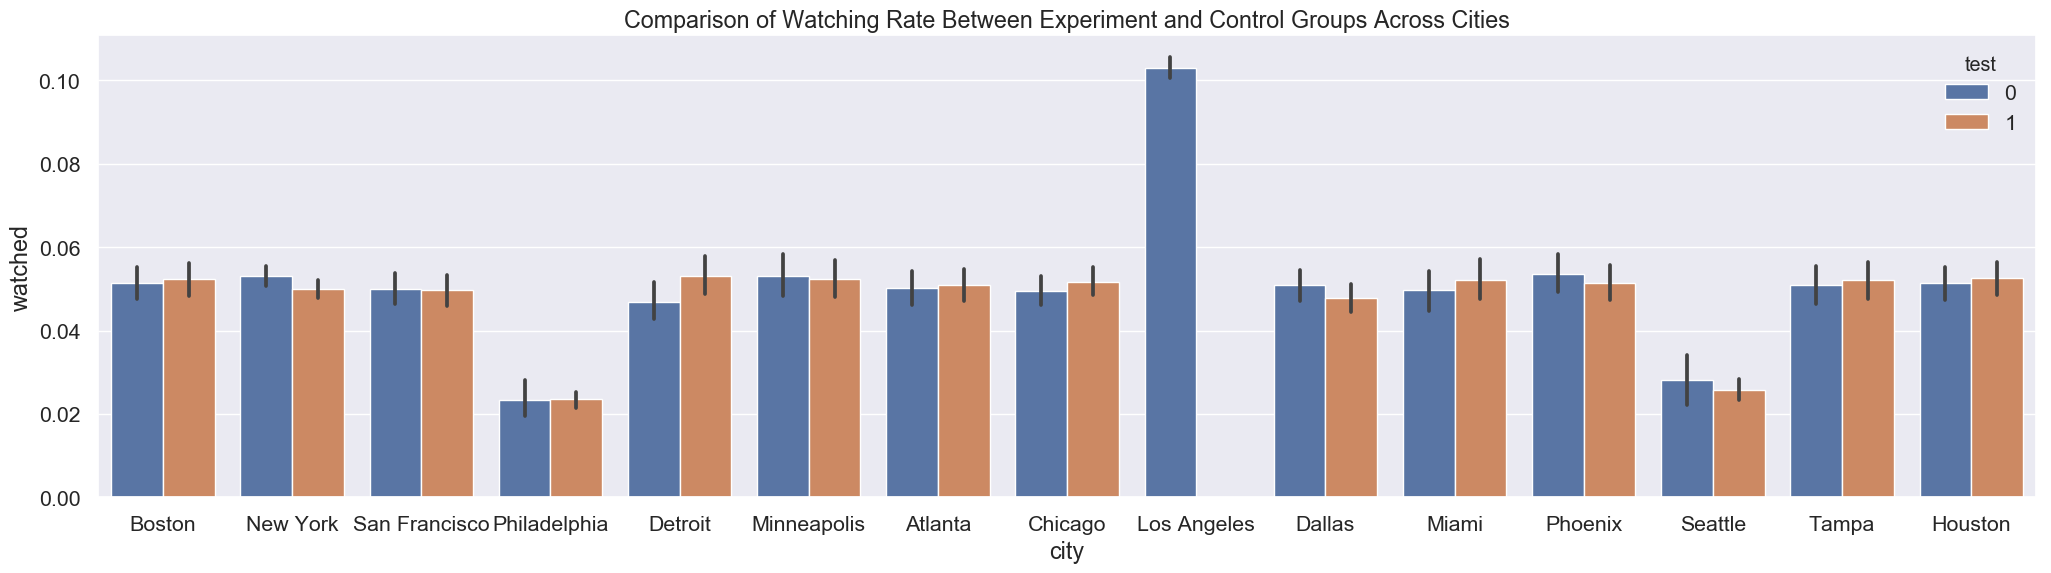

In [49]:
# Visualization the comparisons across cities
fig = plt.figure(figsize = (25, 6))
sns.set(font_scale = 1.4)
sns.barplot(x='city', y='watched', hue='test', data=merged_data)
plt.title('Comparison of Watching Rate Between Experiment and Control Groups Across Cities')

Check out the proportion of viewers from different cities in the experiment vs. control groups

In [50]:
city_ls = [name for name in merged_data['city'].unique() if name is not np.nan]

print('{0:15s} {1:>20s} {2:>30s} {3:>25s}'.format('City', 'Proportion in Control','Proportion in Experiment',
                                         'Proportion Difference'))
print('-' * 95)
for city in city_ls:
    ctrl_proportion = (len(merged_data[(merged_data.test == 0) & (merged_data.city == city)])
                        /len(merged_data[merged_data.test == 0]))
    exp_proportion = (len(merged_data[(merged_data.test == 1) & (merged_data.city == city)])
                        /len(merged_data[merged_data.test == 1]))
    difference = ctrl_proportion - exp_proportion
    
    print('{0:15s} {1:15.5f} {2:25.5f} {3:30.5f}'.format(city, ctrl_proportion, exp_proportion, difference))
    

City            Proportion in Control       Proportion in Experiment     Proportion Difference
-----------------------------------------------------------------------------------------------
Boston                  0.05502                   0.06196                       -0.00694
New York                0.15949                   0.17527                       -0.01578
San Francisco           0.05471                   0.06171                       -0.00700
Philadelphia            0.01994                   0.11988                       -0.09994
Detroit                 0.04089                   0.04499                       -0.00409
Minneapolis             0.03839                   0.04450                       -0.00612
Atlanta                 0.05488                   0.06166                       -0.00678
Chicago                 0.07512                   0.08316                       -0.00803
Los Angeles             0.24573                   0.00000                        0.24573
Dallas  

Out of control group viewers, around 24.57% of them are LA viewers, whom we have already noticed to be more likely to watch the show. Their higher watching rate is driving the rate of control group. <br>
**Comparisons of watching rate between experiment and control for non-LA cities show no significant differences using significance level as 0.05**

**When conducting A/B tests, we want to balance the experiment and control group with regard to factors that may affect the depedent variable. In this case, cities seem to be a related factor.**<br>

Also note Philadelphia viewers composed 11.99% of experiment group, but only 1.99% of control group. What do we know about Philadelphia viewers before the test? How did they behave with the old commercial?

Text(0.5, 1.0, 'Comparison of Watching Rate Across Cities with the Old Commercial (control condition) ')

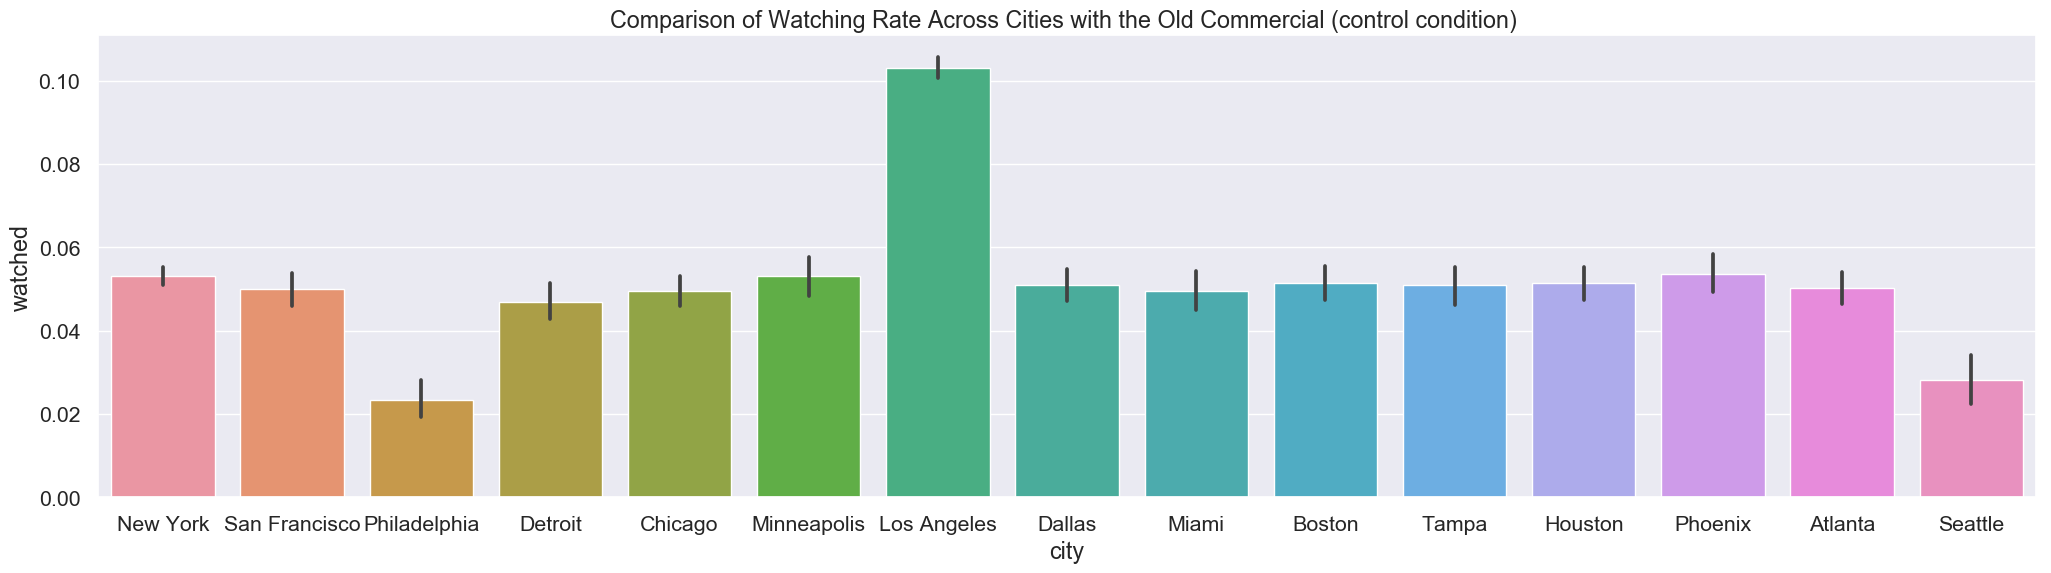

In [51]:
# Check the watching rate across cities under control condition, which could represents the historical performance
# of different cities
fig = plt.figure(figsize = (25, 6))
sns.set(font_scale = 1.4)
sns.barplot(x = merged_data[merged_data.test == 0].city, y = merged_data[merged_data.test == 0].watched)
plt.title('Comparison of Watching Rate Across Cities with the Old Commercial (control condition) ')

Philadelphia and Seattle have relatively low watching rate comparing to other non-LA cities. <br>
It appears that **Philadephia** viewers were unwilling-to-watch viewers. With this in mind, more importantly, it composed 11.99% of the experimental group, which may potentially drive the watching rate of experiment group down.<br>

Recall the proportions of viewers in experiment vs. control groups for different cities, **Seattle** viewers composed 7.76% of experiment group, whereas they only composed 1.33% of control group. Similiar to Philadephia, Seattle viewers were unwilling-to-watch viewers. With them composing higher portion of the experiment group might drive the watching rate of the experiment group down too. 

**In other words, the issue of this A/B test could be that viewers in some cities were not equally likely to be assigned to either experiment or control group. They are biased to be assigned to one of them. For example, viewers in LA all have to be assigned to the control group. Viewers in Philadelphia and Seattle were more likely to be assigned to the experiment group.** 

## Any Other factors?
Explore if other factors affect the test results <br>
To avoid the effects from the high watching rate city LA and low watching rate cities Philadephia and Seattle, when exploring other factors, I compared results from the entire data set and the one excluding these cities 

In [21]:
regular_cities = merged_data[~merged_data.city.isin(['Los Angeles','Philadelphia','Seattle',np.nan])]
regular_cities.city.unique()
regular_cities.to_csv('./data/regular_cities.csv')

array(['Boston', 'New York', 'San Francisco', 'Detroit', 'Minneapolis',
       'Atlanta', 'Chicago', 'Dallas', 'Miami', 'Phoenix', 'Tampa',
       'Houston'], dtype=object)

### Does total time watched matter?

Text(0.5, 1.0, 'Distribution of Viewers Who Watched the Show over Total Time')

Text(0.5, 1.0, 'Distribution of Viewers Who Not Watched the Show over Total Time')

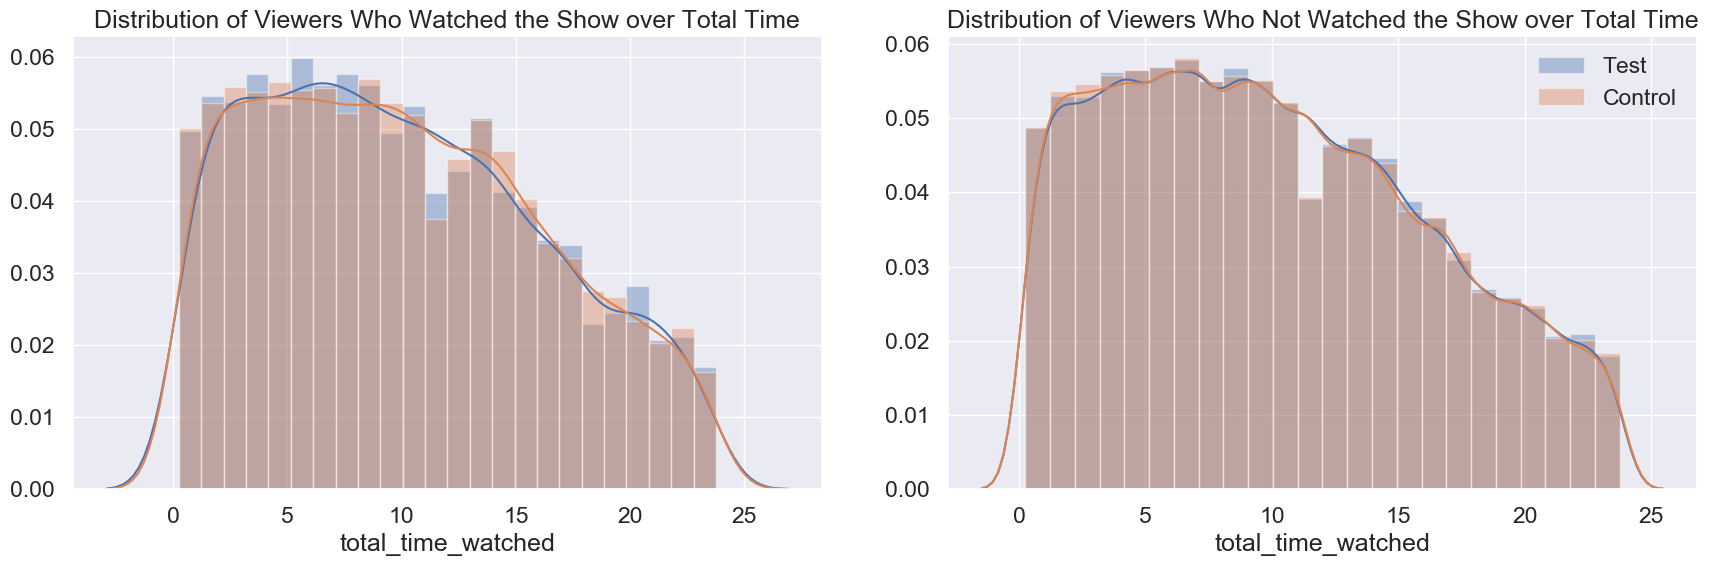

In [60]:
# Visualization of the distribution of total time watched for the entire data set 
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.set(font_scale = 1.5)
sns.distplot(merged_data[(merged_data.test == 1)&(merged_data.watched == 1)].total_time_watched, 
                   label = 'Test',bins = 24, kde=True, ax=ax1)
sns.distplot(merged_data[(merged_data.test == 0)&(merged_data.watched == 1)].total_time_watched, 
                   label = 'Control',bins = 24,kde=True, ax=ax1)
ax1.set_title('Distribution of Viewers Who Watched the Show over Total Time')

sns.distplot(merged_data[(merged_data.test == 1)&(merged_data.watched == 0)].total_time_watched, 
                   label = 'Test',bins = 24,kde=True, ax=ax2)
sns.distplot(merged_data[(merged_data.test == 0)&(merged_data.watched == 0)].total_time_watched, 
                   label = 'Control',bins = 24,kde=True, ax=ax2)
ax2.set_title('Distribution of Viewers Who Not Watched the Show over Total Time')
plt.tight_layout()
plt.legend()

From the plots above, I noticed that the distributions of total time watching TV were similiar between viewers in the test and control groups, and between viewers who watched the show and who did not.<br>

To check statistically, I could run a 2(Condition: test vs. control) * 2(Action: watched vs. not watched) ANOVA on the total time watching TV.

In [64]:
condition = merged_data.test
action = merged_data.watched
formula = 'merged_data.total_time_watched ~ C(condition) + C(action) + C(condition):C(action)'
model = ols(formula, merged_data).fit()
aov_table = statsmodels.stats.anova.anova_lm(model,typ=2)
print(aov_table)

                              sum_sq        df         F    PR(>F)
C(condition)            4.260489e+01       1.0  1.115630  0.290862
C(action)               1.825459e-01       1.0  0.004780  0.944880
C(condition):C(action)  2.291125e+01       1.0  0.599942  0.438600
Residual                1.596388e+07  418022.0       NaN       NaN


There are no significant differences of total TV watching time between test and control groups, show-watched and not-watched groups. 

What about the regular cities?

Text(0.5, 1.0, 'Distribution of Viewers Who Watched the Show over Total Time')

Text(0.5, 1.0, 'Distribution of Viewers Who Not Watched the Show over Total Time')

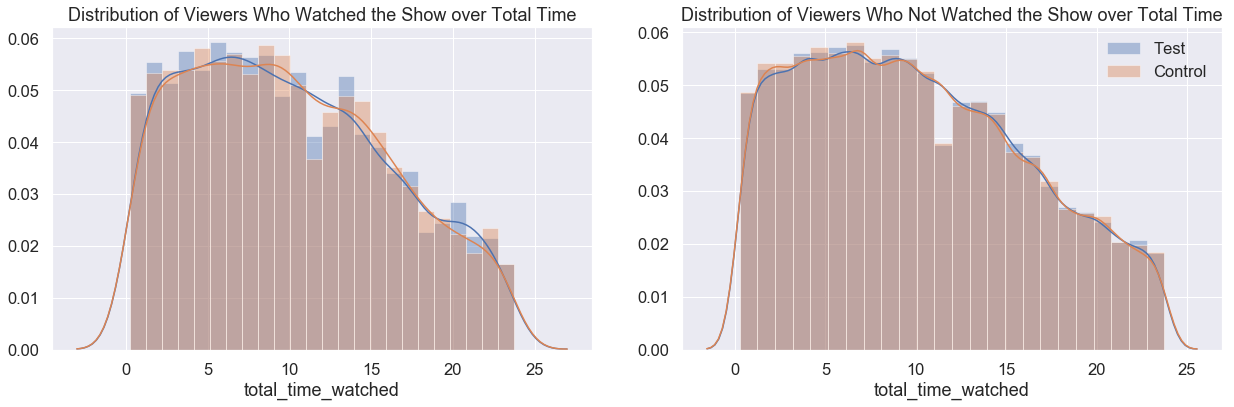

In [66]:
# Visualization of the distribution of total time watched for regular cities
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.set(font_scale = 1.5)
sns.distplot(regular_cities[(regular_cities.test == 1)&(regular_cities.watched == 1)].total_time_watched, 
                   label = 'Test',bins = 24, kde=True, ax=ax1)
sns.distplot(regular_cities[(regular_cities.test == 0)&(regular_cities.watched == 1)].total_time_watched, 
                   label = 'Control',bins = 24,kde=True, ax=ax1)
ax1.set_title('Distribution of Viewers Who Watched the Show over Total Time')

sns.distplot(regular_cities[(regular_cities.test == 1)&(regular_cities.watched == 0)].total_time_watched, 
                   label = 'Test',bins = 24,kde=True, ax=ax2)
sns.distplot(regular_cities[(regular_cities.test == 0)&(regular_cities.watched == 0)].total_time_watched, 
                   label = 'Control',bins = 24,kde=True, ax=ax2)
ax2.set_title('Distribution of Viewers Who Not Watched the Show over Total Time')
plt.tight_layout()
plt.legend()

The distributions appear to be very similiar to those for the entire data set. <br>
Maybe a 2(Condition: test vs. control) * 2(Action: watched vs. not watched)* 15(city) ANOVA on the total time watching TV would answer my curiosity whether samples are evenly assigned across conditions and cities.

In [69]:
city = merged_data.city
formula = 'merged_data.total_time_watched ~ C(condition) + C(action) + C(city) + C(condition):C(action) + C(city):C(action) + C(condition):C(city)'
model = ols(formula, merged_data).fit()
aov_table = statsmodels.stats.anova.anova_lm(model,typ=2)
print(aov_table)

                              sum_sq        df         F    PR(>F)
C(condition)            4.984681e+01       1.0  1.305071  0.253290
C(action)               6.531126e-01       1.0  0.017100  0.895961
C(city)                 4.295686e+02      14.0  0.803344  0.657330
C(condition):C(action)  1.726939e+00       1.0  0.045214  0.831611
C(city):C(action)       3.741903e+02      14.0  0.699780  0.776874
C(condition):C(city)    6.204483e+02      14.0  1.160311  0.302140
Residual                1.594343e+07  417425.0       NaN       NaN


The above ANOVA table shows no significant main effects or interactions, ps > 0.05. Therefore, I have ruled out the effects of total TV watching time on whether viewers watch vs. not watch the show and whether they were assigned to test vs. control conditions.

### Does TV provider matter?

For the sake of time, I'll run statistic tests first and if there are significance results, I will plot figures to get better ideas. <br>

To test if TV provider matters, I use generalized linear model to analyze whether viewers watched the show or not with regard to condition (test vs. control), tv provider, city, and their interactions. Because the dependent variable is binary (watch vs. not), generalized linear model of binomial family is needed.

In [71]:
provider = merged_data.tv_provider

formula = 'action ~ C(condition) + C(provider) + C(city) + C(condition):C(provider) + C(condition):C(city) + C(city):C(provider)'
logit_model = smf.glm(formula, merged_data, family = sm.families.Binomial()).fit()
print(logit_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 action   No. Observations:               364826
Model:                            GLM   Df Residuals:                   364733
Model Family:                Binomial   Df Model:                           92
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -76112.
Date:                Wed, 12 Jun 2019   Deviance:                   1.5222e+05
Time:                        13:22:25   Pearson chi2:                 3.65e+05
No. Iterations:                   100   Covariance Type:             nonrobust
                                                                coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------
Intercept                            

The table is long because of the 15 levels of city and their interactions with other factors. <br>
For the question I care here, there were no significant differences between TV providers on watching the show or not.<br>

With regard to the big problem, useful info are:
* In general, being a LA viewer increases the probability of watching the show
* In general, being a Philadephia, Seattle, or Miami viewer decreases the probability of watching the show to some extent
* In general, being a Seattle viewer, using DirecTV increases the probability of watching
* In general, being a Miami viewer, using DirecTV or Time Warner Cable increases the probability of watching
* In general, being a Houston or Phoenix viewer, using Time Warner Cable increases the probability of watching

### Does viewer gender matter?

In [72]:
gender = merged_data.gender

formula2 = 'action ~ C(condition) + C(gender) + C(city) + C(condition):C(gender) + C(condition):C(city) + C(city):C(gender)'
logit_model2 = smf.glm(formula2, merged_data, family = sm.families.Binomial()).fit()
print(logit_model2.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                 action   No. Observations:               417470
Model:                            GLM   Df Residuals:                   417425
Model Family:                Binomial   Df Model:                           44
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -86922.
Date:                Wed, 12 Jun 2019   Deviance:                   1.7384e+05
Time:                        13:52:09   Pearson chi2:                 4.17e+05
No. Iterations:                     7   Covariance Type:             nonrobust
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                     -2.9314      0.052   

There was no significant difference between genders on watching the show or not.

With this GLM model, the positive effect of being a LA viewer and the negative effects of being a Philadephia, or Seattle viewer are replicated.

### Does viewer age matter?

In [3]:
merged_data = pd.read_csv('./Data/merged_data.csv')

In [4]:
# Group ages for easy process
def group_age(age):
    if age <= 40:
        return 'young'
    elif age <= 60:
        return 'middle'
    else:
        return 'senior'

In [5]:
merged_data['age_group'] = merged_data.age.apply(lambda x: group_age(x))

In [6]:
merged_data.age_group.unique()
merged_data.head()

array(['middle', 'young', 'senior'], dtype=object)

,Unnamed: 0,viewer_id,date,tv_make,tv_size,uhd_capable,tv_provider,total_time_watched,watched,test,gender,age,city,age_group
0,0,24726768,2018-01-16,Sony,70,0,Comcast,10.75,0,1,Male,52.0,Boston,middle
1,1,25001464,2018-01-18,Sony,32,0,NaN,2.75,0,0,Male,38.0,New York,young
2,2,28291998,2018-01-18,Sony,50,1,Dish Network,20.00,0,0,Female,38.0,San Francisco,young
3,3,17057157,2018-01-19,Sony,32,0,Comcast,1.50,0,0,Male,39.0,Philadelphia,young
4,4,29504447,2018-01-17,Sony,32,0,Comcast,17.50,0,0,Female,57.0,Detroit,middle


In [7]:
merged_data.to_csv('./Data/merged_data.csv')

In [4]:
merged_data = pd.read_csv('./Data/merged_data.csv')

In [48]:
age_group = merged_data.age_group
action = merged_data.watched
condition = merged_data.test
city = merged_data.city

# To avoid repeated info, I only considered the interaction between age and city and the interaction between age 
# and condition  
formula3 = 'action ~ C(condition) + C(age_group) + C(city) + C(condition):C(age_group) + C(city):C(age_group)'
logit_model3 = smf.glm(formula3, merged_data, family = sm.families.Binomial()).fit()
print(logit_model3.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 action   No. Observations:               417470
Model:                            GLM   Df Residuals:                   417422
Model Family:                Binomial   Df Model:                           47
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -86924.
Date:                Wed, 12 Jun 2019   Deviance:                   1.7385e+05
Time:                        15:19:40   Pearson chi2:                 4.17e+05
No. Iterations:                     7   Covariance Type:             nonrobust
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                                          -2.996

Similarly, there were no main effects of age groups. There are two interactions which are senior viewers with condition and senior viewers with Houston. There interactions are not directly related to the questions I was asked. <br>

**It appears that the negative results of A/B test are mainly caused by unbalanced condition assignment of viewers in some cities. LA viewers are willing-to-watch users and they composed a good portion of control group, driving the group watching rate up. Philadephia and Seattle viewers are unwilling-to-watch users and they composed a good portion of experiment group, driving the group watching rate down.** <br>

**To summarize, the current A/B test results are not trustworthy due to unbalanced composition of samples between control and test group. We don't have enough evidence showing the new commercial is worse.**

# Write an algorithm to flag out the problem for future practice
* Ideally, A/B test should implement randomised control trials, meaning subjects are randomly assigned to either the control group or the experiment group. With a large sample size, each subject in the sample should be equally likely to be assigned to either group, i.e., the probability equals 0.5.

* The current experiment violates random assignment in two parts:
    * All LA viewers were counted in the control group. There is no random assignment for LA viewers at all
    * Philadelphia and Seattle viewers seem to have a higher probability to be assigned to the experiment group

In [5]:
def sanity_check(size1, size2, significance = 0.05):
    n = size1 + size2
    confidence = 1 - significance
    z = scipy.stats.norm.ppf(confidence + significance / 2)
    confint = n * 0.5 + np.array([-1, 1]) * np.sqrt(n * 0.5 * 0.5)
    # shouldn't this be: 
  # confint = n * 0.5 + np.array([-1, 1]) * z * np.sqrt(n * 0.5 * 0.5)  
    return confint

In [26]:
# Check the likelihood of viewers in each city to be assigned to either group
print('{0:10s} {1:>15s} {2:>20s} {3:>20s} {4:>13s} {5:>14s} {6:>14s}'.format('City', 'Sample Size','CI of Size',
                                         'Experiment Size', 'Control Size','Exp within CI','Ctrl within CI'))
print('-' * 112)

city_ls = [name for name in merged_data['city'].unique() if name is not np.nan]
exp_n_ls = []
ctrl_n_ls = []
for city in city_ls:
    n_city = len(merged_data[merged_data.city == city])
    exp_n = len(merged_data[(merged_data.test == 1) & (merged_data.city == city)])
    exp_n_ls.append(exp_n)
    
    ctrl_n = len(merged_data[(merged_data.test == 0) & (merged_data.city == city)])
    CI = sanity_check(exp_n, ctrl_n)
    ctrl_n_ls.append(ctrl_n)
    
    exp_w_CI = True if exp_n > CI[0] and exp_n < CI[1] else False
    ctrl_w_CI = True if ctrl_n > CI[0] and ctrl_n < CI[1] else False
    
    print('{0:10s} {1:>10d} {2:>35s} {3:>10d} {4:>10d} {5:>12s} {6:>14s}'.format(city, n_city, str(CI), exp_n, ctrl_n,
                                                                      str(exp_w_CI),str(ctrl_w_CI)))
    

City           Sample Size           CI of Size      Experiment Size  Control Size  Exp within CI Ctrl within CI
----------------------------------------------------------------------------------------------------------------
Boston          24418     [12130.86870025 12287.13129975]      12660      11758        False          False
New York        69894     [34814.81263298 35079.18736702]      35812      34082        False          False
San Francisco      24300     [12072.05771366 12227.94228634]      12609      11691        False          False
Philadelphia      28756     [14293.21202916 14462.78797084]      24495       4261        False          False
Detroit         17931       [8898.54665804 9032.45334196]       9192       8739        False          False
Minneapolis      17296       [8582.24287111 8713.75712889]       9093       8203        False          False
Atlanta         24327     [12085.51442441 12241.48557559]      12599      11728        False          False
Chicago     

**Note in this case, viewers from every city were not equally likely to be assigned to experiment or control groups**

Alternatively, I used the chi-square test of independence to check if cities are associated with the assignment of conditions, i.e., whether viewers from some cities are more likely to be assigned to one of the conditions 

In [35]:
observed_number = np.array([exp_n_ls, ctrl_n_ls])

In [32]:
from scipy import stats
stats.chi2_contingency(observed_number)

(76002.41785407714,
 0.0,
 14,
 array([[11951.17418258, 34209.0002587 , 11893.420126  , 14074.36992359,
          8776.16939421,  8465.37425923, 11906.63503725, 16173.58304788,
         25702.02350109, 13058.77952188,  8459.9904065 ,  9461.87645579,
          9150.59187966,  9106.05273433, 11937.95927132],
        [12466.82581742, 35684.9997413 , 12406.579874  , 14681.63007641,
          9154.83060579,  8830.62574077, 12420.36496275, 16871.41695212,
         26810.97649891, 13622.22047812,  8825.0095935 ,  9870.12354421,
          9545.40812034,  9498.94726567, 12453.04072868]]))

In this case, chi-square = 76002.42, p = 0, df = 14, indicating that the condition assignment is not independent from cities.<br>

To formalize an algorithm, it could be (use some of the codes above):

In [46]:
def eval_condition_assignment(df, related_factor):
    factor_levels = [level for level in df[related_factor].unique() if level is not np.nan]
    exp_n_ls = []
    ctrl_n_ls = []
    for level in factor_levels:
        exp_n = len(merged_data[(merged_data.test == 1) & (merged_data.city == city)])
        exp_n_ls.append(exp_n)

        ctrl_n = len(merged_data[(merged_data.test == 0) & (merged_data.city == city)])
        ctrl_n_ls.append(ctrl_n)
    
    observed_number = np.array([exp_n_ls, ctrl_n_ls])
    from scipy import stats
    statistic_values = stats.chi2_contingency(observed_number)
    
    if statistic_values[1] < 0.05:
        print('False')
    return False

In [47]:
eval_condition_assignment(merged_data,'city')

False

# Future Directions
* Automated a pipeline with consideration of determining sample size based on power analysis
* More guidance and implementation in actually assign viewers and collecting data in an unbiased way 